In [303]:
from py_vollib.black_scholes import black_scholes as bs 
from py_vollib.black_scholes.greeks.analytical import vega 

## Calculate the implied volatility of an Option using Newton-Raphson Method

In [329]:
def implied_vol(S0,K,T,r,market_price,flag='c',tol=0.000001):
    max_iterations = 200
    vol_old = 0.3

    for k in range(max_iterations):
        bs_old_price = bs(flag, S0, K, T, r, vol_old)
        C_prime = vega(flag, S0, K, T, r, vol_old)*100 #Dans le module est considéré comme la déviation de l'option pour une déviation de 1% dans la vol 
        C = bs_old_price - market_price
        vol_new = vol_old + C/C_prime
        C = bs_old_price - market_price
        vol_new = vol_old - C/C_prime
        bs_new_price = bs(flag, S0, K, T, r, vol_new)
        if (abs(vol_old - vol_new) < tol or abs(bs_new_price - market_price) < tol):
            break
        vol_old = vol_new
    implied_vol = vol_new
    return implied_vol 

## Tracer la surface de implied volatility

In [306]:
import pandas as pd
import numpy as np
import scipy as sp
import os
import itertools
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime
from scipy.optimize import fsolve
from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

In [307]:
ticker_symbol = "AMZN"
ticker = yf.Ticker(ticker_symbol)

data = ticker.history(period="1d")  # Récupère les données du dernier jour de marché
closing_price = data['Close'].iloc[-1]
r = 0.045

In [309]:
ticker_symbol = "AAPL"
ticker = yf.Ticker(ticker_symbol)
expirations = ticker.options
df_option_datas = []

for exp in expirations:
    opt_chain = ticker.option_chain(exp)  # Récupérer les options pour la date exp
    
    for type_, opt_df in zip(['CALL', 'PUT'], [opt_chain.calls, opt_chain.puts]):
        for _, row in opt_df.iterrows():  
            strike = row['strike']
            midprice = row['lastPrice']
            expiration_date = exp

            df_option_datas.append([expiration_date, strike, midprice, type_])


df_option_datas = pd.DataFrame(df_option_datas, columns=['expiration_date', 'strike', 'midprice', 'type'])
df_option_datas['expiration_date'] = pd.to_datetime(df_option_datas['expiration_date'])
df_option_datas = df_option_datas[(df_option_datas['strike'] > 170) & (df_option_datas['strike'] < 300)]
df_option_datas['days_to_expiration'] = (df_option_datas['expiration_date'] - pd.Timestamp(datetime.today())).dt.days
df_option_datas = df_option_datas[['days_to_expiration', 'expiration_date', 'strike', 'midprice', 'type']]
df_option_table = df_option_datas.pivot_table(index=['days_to_expiration', 'strike'], columns='type', values='midprice')

In [310]:
df_option_table

type                        CALL    PUT
days_to_expiration strike              
2                  175.0   52.00   0.01
                   180.0   51.80   0.01
                   185.0   45.30   0.01
                   187.5   47.70   0.02
                   190.0   41.85   0.01
...                          ...    ...
862                250.0   36.33  35.65
                   260.0   31.40  40.49
                   270.0   28.00  46.57
                   280.0   24.10  53.03
                   290.0   20.95  55.25

[522 rows x 2 columns]

In [311]:
def BS(S,K,T,r,vol,type):
    d1 = (np.log(S/K)+(r + vol**2/2)*T)/(vol*np.sqrt(T))
    d2 = d1 - vol*np.sqrt(T)
    if type == "call":
        return S*N(d1) - K*np.exp(-r*T)*N(d2)
    else :
        return K*np.exp(-r*T)*N(-d2)-S*N(-d1)

In [312]:
def BSM(sigma, S0, K, P, T, r, type_):
    d1 = (np.log(S0/K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if type_ == 'CALL':
        return S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2) - P
    elif type_ == 'PUT':
        return K * np.exp(-r * T) * norm.cdf(-d2) - P - S0 * norm.cdf(-d1)


In [313]:
our_type = "CALL"
flag = 'c'

In [314]:
imp_vol_df = []
maturity ,strike = [],[]

for index, value in df_option_table[our_type].items():
    T = index[0]/365
    K = index[1]
    sigma0 = 0.6
    maturity.append(T)
    strike.append(K)
    imp_vol = fsolve(BSM, sigma0, args=(closing_price, K, value, T, r, our_type), xtol=1e-8, maxfev=500)
    imp_vol_df.append(float(imp_vol))

/var/folders/q6/w6mg99v94cd8ptz_m5r4q2g40000gn/T/ipykernel_33499/16293437.py:10: RuntimeWarning:

The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.

/var/folders/q6/w6mg99v94cd8ptz_m5r4q2g40000gn/T/ipykernel_33499/16293437.py:11: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



In [315]:
df_vol = pd.DataFrame(list(zip(imp_vol_df, maturity, strike)), columns=['implied_volatility', 'days_to_expiration', 'strike'])
df_vol

,implied_volatility,days_to_expiration,strike
0,0.505660,0.005479,175.0
1,0.383844,0.005479,180.0
2,0.411226,0.005479,185.0
3,0.378079,0.005479,187.5
4,0.346768,0.005479,190.0
...,...,...,...
517,0.188130,2.361644,250.0
518,0.186179,2.361644,260.0
519,0.191492,2.361644,270.0
520,0.190250,2.361644,280.0


## Plot the Smile 

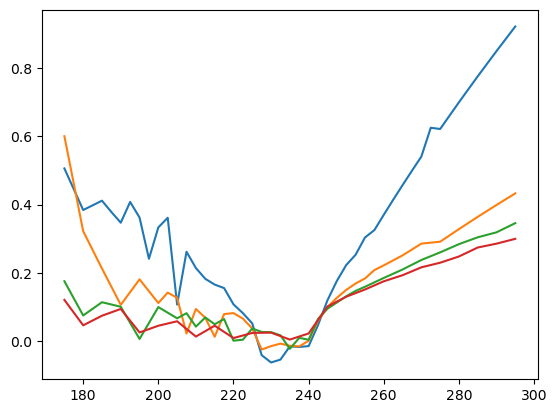

In [316]:
list_daytoexp = df_vol['days_to_expiration'].drop_duplicates().tolist()

for i in range(4):
    a = df_vol[df_vol['days_to_expiration']==list_daytoexp[i]]
    plt.plot(a['strike'].tolist(),a['implied_volatility'].tolist())

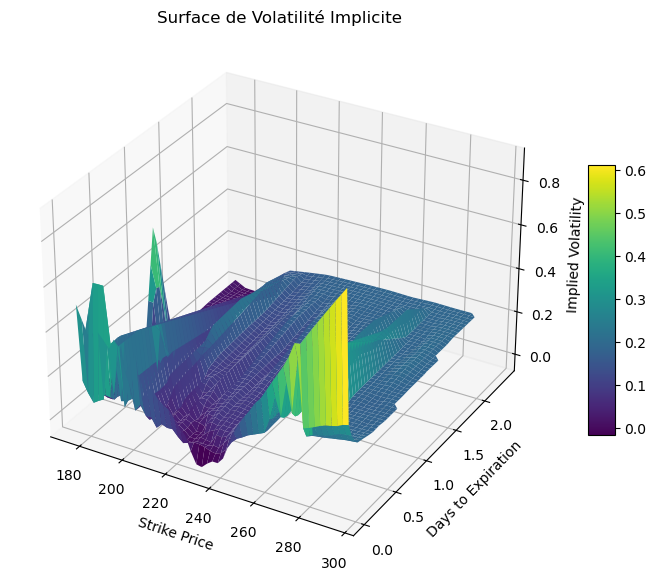

In [317]:
X = df_vol['strike']
Y = df_vol['days_to_expiration']
Z = df_vol['implied_volatility']

# Création d'une grille pour interpolation
xi = np.linspace(X.min(), X.max(), 50)
yi = np.linspace(Y.min(), Y.max(), 50)
X_grid, Y_grid = np.meshgrid(xi, yi)
Z_grid = griddata((X, Y), Z, (X_grid, Y_grid), method='linear')

# Tracer la surface
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X_grid, Y_grid, Z_grid, cmap='viridis', edgecolor='none')

# Labels
ax.set_xlabel('Strike Price')
ax.set_ylabel('Days to Expiration')
ax.set_zlabel('Implied Volatility')
ax.set_title('Surface de Volatilité Implicite')

# Barre de couleur
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

plt.show()

In [319]:
import plotly.graph_objects as go
import numpy as np
from scipy.interpolate import griddata

# Exemple de données, remplace-les par tes propres données
X = df_vol['strike']
Y = df_vol['days_to_expiration']
Z = df_vol['implied_volatility']

# Création d'une grille pour interpolation
xi = np.linspace(X.min(), X.max(), 50)
yi = np.linspace(Y.min(), Y.max(), 50)
X_grid, Y_grid = np.meshgrid(xi, yi)
Z_grid = griddata((X, Y), Z, (X_grid, Y_grid), method='linear')

# Création de la surface avec Plotly
fig = go.Figure(data=[go.Surface(z=Z_grid, x=X_grid, y=Y_grid)])

# Labels
fig.update_layout(
    title='Surface de Volatilité Implicite',
    scene=dict(
        xaxis_title='Strike Price',
        yaxis_title='Days to Expiration',
        zaxis_title='Implied Volatility'
    ),
    coloraxis_colorbar=dict(title="Implied Volatility")
)

# Affichage
fig.show()

In [321]:
#FRED API : 54dc21b344d021c79ae6bcd13013fd62

fred = Fred(api_key='54dc21b344d021c79ae6bcd13013fd62')


# Get risk-free rate with zero rates bonds
def get_riskfree_rate():

    # Load all data available in Fred API : zero rate for these bonds
    data_3m = fred.get_series('DGS3MO', observation_start='2024-01-01', observation_end=datetime.today())
    data_6m = fred.get_series('DGS6MO', observation_start='2024-01-01', observation_end=datetime.today())
    data_1y = fred.get_series('DGS1', observation_start='2024-01-01', observation_end=datetime.today())
    data_2y = fred.get_series('DGS2', observation_start='2024-01-01', observation_end=datetime.today())
    data_3y = fred.get_series('DGS3', observation_start='2024-01-01', observation_end=datetime.today())
    data_5y = fred.get_series('DGS5', observation_start='2024-01-01', observation_end=datetime.today())
    data_7y = fred.get_series('DGS7', observation_start='2024-01-01', observation_end=datetime.today())
    data_10y = fred.get_series('DGS10', observation_start='2024-01-01', observation_end=datetime.today())

    # Concatenation of these data
    dataset = pd.concat([data_3m, data_6m, data_1y, data_2y, data_3y, data_5y, data_7y, data_10y], axis=1)
    dataset.columns = ['3', '6', '12', '24', '36', '60', '84', '120']
    dataset.dropna(inplace=True)

    # Re-arrange with new empty columns corresponding to the other months
    all_months = [str(month) for month in range(1, 121)]
    missing_columns = [month for month in all_months if month not in dataset.columns]
    missing_df = pd.DataFrame(np.nan, index=dataset.index, columns=missing_columns)

    dataset = pd.concat([dataset, missing_df], axis=1)
    dataset=dataset[all_months]

    # Interpolate
    dataset = dataset.interpolate(method='linear', axis=1)
    riskfree_rate = dataset.iloc[-1, :]
    #riskfree_rate.dropna(axis=0, inplace=True)

    return riskfree_rate #rf for all months